Author: Zidong Chen<br />
Date: 2024/6/22<br />
Description: This is a simple implementation of non_positive_definite_fixer.<br />
Note: When encountering a non-positive definite matrix during optimization, the easiest and fastest way to fix it is to reduce the learning rate.

In [41]:
import torch
from non_positive_definite_fixer import remove_similar_data, Gaussian_log_likelihood, train_adam_with_reset
from kernel import ARDKernel
from matplotlib import pyplot as plt
import GP_CommonCalculation as GP
import torch.nn as nn


JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

xtr.size: torch.Size([100, 1]) ytr.size: torch.Size([100, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


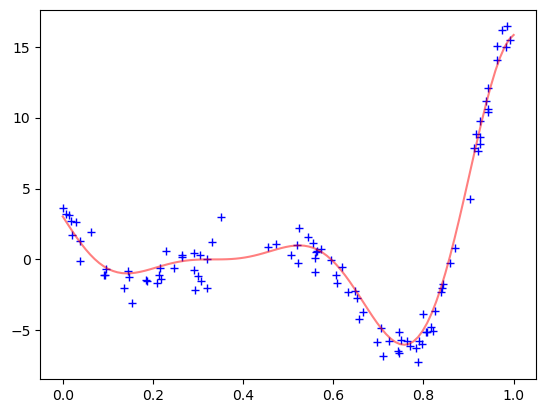

In [36]:
torch.manual_seed(4)
xtr = torch.rand(100, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

In [45]:
class cigp(nn.Module):
    def __init__(self, X, Y, normal_y_mode=0):
        # normal_y_mode = 0: normalize Y by combing all dimension.
        # normal_y_mode = 1: normalize Y by each dimension.
        super(cigp, self).__init__()
        self.kernel=ARDKernel(1)
        self.data = GP.XYdata_normalization(X, Y, normal_y_mode)
        self.X, self.Y = self.data.normalize(X, Y)
        self.X, self.Y = remove_similar_data(self.X, self.Y) # implement on remove_similar_data in non_positive_definite_fixer
        

        # noise variance
        self.log_beta = nn.Parameter(torch.ones(1) * 0)

    def forward(self, Xte):
        Xte = self.data.normalize(Xte)
        sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(
        self.X.size(0))
        K_xt = self.kernel(self.X, Xte)
        K_tt = self.kernel(Xte,Xte)
        
        mean,var= GP.conditional_Gaussian(self.Y, sigma, K_xt, K_tt)
        var_diag = var.diag().view(-1, 1)
        # de-normalized
        mean, var_diag = self.data.denormalize_result(mean, var_diag)
        return mean, var_diag


    def negative_lower_bound(self):
        K_xx=self.kernel(self.X,self.X)+JITTER * torch.eye(self.X.size(0))
        return -Gaussian_log_likelihood(self.Y, K_xx, Kinv_method='eigen') # implement on eigendecomposition in non_positive_definite_fixer
    

In [46]:
model=cigp(xtr,ytr)
# implement on parameter_reset in non_positive_definite_fixer
train_adam_with_reset(model, niteration=40)

Iteration 10: Loss: 1411.04480
Iteration 20: Loss: 357.42639
Iteration 30: Loss: 213.93326
Iteration 40: Loss: 138.93300


torch.Size([100, 1])


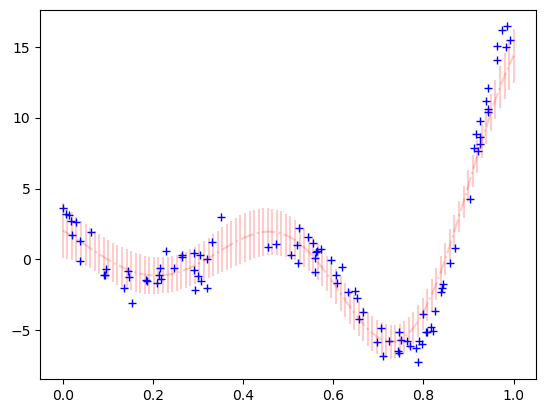

In [47]:
with torch.no_grad():
    ypred, yvar = model.forward(xte)
print(yvar.size())   
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()